In [1]:
import sys

# in order to import the modules located at the root directory
sys.path.append("..")

In [2]:
import logging
from importlib import reload  # Not needed in Python 2

reload(logging)
logging.basicConfig(
    format="%(message)s",
    level=logging.DEBUG,
)

LOGGER = logging.getLogger(__name__)

In [3]:
from mrs.utils import SessionBuilder
from mrs.finetune_dataset import FinetuneDataset

builder = SessionBuilder(style="formal")
train_dataset = FinetuneDataset(builder=builder, train=True)
valid_dataset = FinetuneDataset(builder=builder, train=False)

Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Starting new HTTPS connection (1): huggingface.co:443
https://huggingface.co:443 "HEAD /klue/roberta-base/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
Number of sessions: 236
https://huggingface.co:443 "HEAD /klue/roberta-base/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
Number of sessions: 236


In [4]:
from torch.utils.data import DataLoader
from mrs.finetune_dataset import FinetuneDatasetCollator

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=FinetuneDatasetCollator(
        pad_idx=train_dataset.tokenizer.pad_token_id, max_length=99999
    ),
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=FinetuneDatasetCollator(
        pad_idx=valid_dataset.tokenizer.pad_token_id, max_length=99999
    ),
)

In [5]:
import torch
import torch.nn as nn
from transformers import RobertaForMaskedLM


class FinetuneModel(nn.Module):
    def __init__(self, input_size):
        super(FinetuneModel, self).__init__()
        # defined in huggingface PreTrainedTokenizer
        # input_size = len(tokenizer) = tokenizer.vocab_size + len(tokenizer.added_tokens_encoder)

        self.model = RobertaForMaskedLM.from_pretrained("klue/roberta-base")
        self.model.resize_token_embeddings(input_size)

        hidden_size = self.model.config.hidden_size

        # `generator` used in postmodel will not be used in Finetuning Model
        # instead, here use `W` as the name of variable to compress the embedding dimension.
        # therefore, when loading state dictionary (model params) of the PostModel,
        # the `strict=False` parameter must be specified in order to avoid error.
        self.w = nn.Linear(hidden_size, 2)

    def forward(self, batch_input_tokens, batch_input_attentions):
        # binary classification
        outputs = self.model(
            input_ids=batch_input_tokens,
            attention_mask=batch_input_attentions,
            output_hidden_states=True,
        )["hidden_states"][-1]
        # |outputs| = (bs*5, length, hidden_size)
        # 5 = number of sessions per batch
        cls_outputs = outputs[:, 0, :]
        # |cls_outputs| = (bs*5, hidden_size)
        cls_logits = self.w(cls_outputs)
        # |cls_logits| = (bs*5, 2)
        return cls_logits

In [7]:
fine_model = FinetuneModel(input_size=len(train_loader.dataset.tokenizer))
post_model = torch.load("../data/post_model.bin", map_location="cpu")
fine_model.load_state_dict(post_model, strict=False)
del post_model

https://huggingface.co:443 "HEAD /klue/roberta-base/resolve/main/config.json HTTP/1.1" 200 0
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 32001. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [8]:
from transformers import get_linear_schedule_with_warmup


def get_crit(pad_idx):
    crit = nn.CrossEntropyLoss(ignore_index=pad_idx)
    return crit


def get_optimizer(model, lr):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    return optimizer


training_epochs = 5
max_grad_norm = 10
lr = 1e-5
n_training_steps = len(train_loader) * training_epochs
n_warmup_steps = len(train_loader)
crit = get_crit(pad_idx=train_loader.dataset.tokenizer.pad_token_id)
optimizer = get_optimizer(fine_model, lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=n_warmup_steps, num_training_steps=n_training_steps
)

# load model, criterion to mps
fine_model.to("mps:{}".format(0))
crit.to("mps:{}".format(0))

print("Initialization done.")

Initialization done.


In [20]:
from tqdm import tqdm

loss_traces = []

for epoch in range(training_epochs):
    LOGGER.info(f"**** Training Epoch: {epoch} ****")

    # turn on train mode
    fine_model.train()

    for i, batch in enumerate(tqdm(train_loader)):
        device = next(fine_model.parameters()).device
        optimizer.zero_grad()

        batch_input_tokens, batch_input_attentions, batch_input_labels = (
            batch["batch_input_tokens"].to(device),
            batch["batch_input_attentions"].to(device),
            batch["batch_labels"].to(device),
        )

        # forward model
        outputs = fine_model(batch_input_tokens, batch_input_attentions)
        loss_val = crit(outputs, batch_input_labels)

        loss_traces += [loss_val.item()]

        # backward loss
        loss_val.backward()

        # clip gradient
        torch.nn.utils.clip_grad_norm_(fine_model.parameters(), max_grad_norm)

        optimizer.step()
        scheduler.step()
    break

**** Training Epoch: 0 ****
100%|██████████| 1510/1510 [09:02<00:00,  2.78it/s]


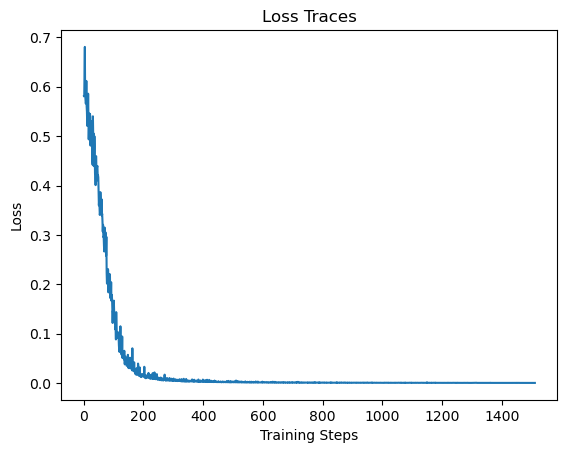

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List


def plot_loss(loss_traces: List):
    plt.plot(np.arange(1, len(loss_traces) + 1), loss_traces)
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Loss Traces")
    plt.show()


plot_loss(loss_traces=loss_traces)

In [ ]:
import os


def save_model(model, path):
    if not os.path.exists(path):
        os.makedirs(path)
    torch.save(model.state_dict(), os.path.join(path, "fine_model.bin"))


save_model(fine_model, "../data")

In [9]:
fine_model = FinetuneModel(input_size=len(train_loader.dataset.tokenizer))
fine_model.load_state_dict(torch.load("../data/fine_model.bin"), strict=True)

https://huggingface.co:443 "HEAD /klue/roberta-base/resolve/main/config.json HTTP/1.1" 200 0
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 32001. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


<All keys matched successfully>

In [142]:
import numpy as np
from tqdm import tqdm


# evaluation
def calc_recall_at_1_score(model: nn.Module, dataloader):
    # b.c. recall 5 at "1" - each batch consists of 1 positive ground true session, 4 negative sessions.
    # thereby only recall/precision@1 metric is available.
    model.eval()
    softmax = nn.Softmax(dim=1)
    bs = dataloader.batch_size

    correct = 0

    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader, desc="evaluation")):
            device = next(model.parameters()).device

            # to gpu
            batch_input_tokens, batch_input_attentions, batch_input_labels = (
                batch["batch_input_tokens"].to(device),
                batch["batch_input_attentions"].to(device),
                batch["batch_labels"].to(device),
            )

            # prediction
            outputs = fine_model(batch_input_tokens, batch_input_attentions)
            # |outputs| = (bs*5, 2)
            probs = softmax(outputs)
            # |probs| = (bs*5, 2)

            # our task is to select the true candidate among the N candidates (here we set as 5)
            # the evaluation process is slightly different from the simple binary classification task.
            true_probs = probs[:, 1]  # 1 here means the positive label index

            pred_indices = []
            for i in range(bs):
                _true_probs = true_probs[i * bs : i * bs + bs]
                # select the candidate has the highest probability, and that one is the predicted candidate
                pred_indices += [_true_probs.argmax(0).item()]
            pred_indices = np.array(pred_indices)

            gt_indices = (batch_input_labels == 1).nonzero().squeeze().numpy()
            correct += ((pred_indices == gt_indices).sum()) / 1

    return correct / len(dataloader)


score = calc_recall_at_1_score(fine_model, valid_loader)

evaluation: 100%|██████████| 107/107 [00:28<00:00,  3.74it/s]


In [144]:
# train only 1 epoch:
print(score)

0.6542056074766355
